In [2]:
# run only if you have not installed the next libraries
"""
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist
"""


'\n!pip install numpy\n!pip install matplotlib\n!pip install scipy\n!pip install getdist\n'

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
%matplotlib inline
dpi=200

# Gradiente de U

$\LARGE U = -\log(L(\textbf{q})p(\textbf{q})) = - \log(L) -  \log(p)$

$\LARGE \nabla_{q} U = -\frac{1}{L}\frac{\partial L}{\partial q} - \frac{1}{p}\frac{\partial p}{\partial q} = -\frac{1}{L}\frac{\partial L}{\partial q}$

Si el prior $p$ es uniforme, $\frac{\partial p}{\partial q} = 0$

$\LARGE \frac{\partial L}{\partial q} = \frac{\partial}{\partial q}(N\exp(-\frac{\chi^{2}}{2})) = -N \chi \exp(-\frac{\chi^{2}}{2})\frac{\partial \chi}{\partial q}$

$\LARGE \frac{\partial \chi}{\partial q} = \frac{\partial}{\partial q}(A - \frac{B^{2}}{C}) = \frac{\partial A}{\partial q} - 2\frac{B}{C} \frac{\partial B}{\partial q}$

$\LARGE \frac{\partial A}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)^{2}}{\sigma_{i}^{2}}) = -\sum_{i}\frac{2(\mu_{i} - \mu)}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial B}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)}{\sigma_{i}^{2}}) = - \sum_{i} \frac{1}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial \mu}{\partial q} = \frac{\partial}{\partial q} (5 \log_{10}(\bar{d}_{L})) = \frac{5}{\log{10}} \frac{1}{\bar{d}_{L}} \frac{\partial \bar{d}_{L}}{\partial q}$

$\LARGE \frac{\partial \bar{d}_{L}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{L}}{d_{H}}) = \frac{1}{d_{H}} \frac{\partial d_{L}}{\partial q}$

$\LARGE \frac{\partial d_{L}}{\partial q} = \frac{\partial}{\partial q}((1 + z)\, d_{M}) = (1 + z)\frac{\partial d_{M}}{\partial q}$

$
\begin{eqnarray}
\frac{\partial\ d_{M}}{\partial q} & = &  \left\{
	\begin{array}{ll}
		\frac{\partial f_{1}}{\partial q} & \mbox{if } \Omega_{k} > 0 \\
		\frac{\partial f_{2}}{\partial q} & \mbox{if } \Omega_{k} = 0 \\
        \frac{\partial f_{3}}{\partial q} & \mbox{if } \Omega_{k} < 0 
	\end{array}
\right.
\end{eqnarray}
$

\begin{align}
        \frac{\partial f_{1}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{H}}{\sqrt\Omega_{k}}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E[z']}))\\
        \frac{\partial f_{1}}{\partial q} = d_{H} [-\frac{1}{2}\Omega_{k}^{-3/2}\frac{\partial \Omega_{k}}{\partial q}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')}) + \Omega_{k}^{-1/2}\cosh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})\frac{\partial}{\partial q}(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})
\end{align}


In [176]:
# Este programa implementa Hamiltonian Markov Chain Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

class PID:
    def __init__(self, kp, ki, kd, o_min, o_max):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.e0 = 0
        self.inte = 0
        self.out = 0
        self.min = o_min
        self.max = o_max

    def set_out(self, e):
        prop = e*self.kp
        deri = (e - self.e0)*self.kd
        if self.out!=1 and self.out!=0: # antiwind up
            self.inte += e*self.ki
        self.out = prop + deri + self.inte
        if self.out>self.max:
            self.out = self.max
        elif self.out<self.min:
            self.out = self.min
   
            
    def set_kp(self, kp):
        self.kp = kp

    def set_ki(self, ki):
        self.ki = ki

    def set_kd(self, kd):
        self.kd = kd


def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_hmc(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep
    
    
def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1    


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/(E + 1e-300), z, initial=0)+z[0]*((1/(E + 1e-300))[0] + 1)/2 # estabilidad numerica
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #f (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + dw
    tb = theta - dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def leapfrog(l, e, dw, theta, m, z, dat, sigma):
    H = []
    qe = theta
    while True:

        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):
  
            #print(i)
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break            
            #print('ant pe', pe)
            #print('ant qe', qe)
            #print('grad', gradiente(dw, qe, z, dat, sigma))
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2
            
            #print('desp pe', pe)
            
            qe = qe + e*pe/m
            if qe[0]<0:
                qe[0] = qe[0]*-1
                pe[0] = pe[0]*-1
            if qe[1]<0:
                qe[1] = qe[1]*-1
                pe[1] = pe[1]*-1
            if qe[2]>1/3:
                qe[2] = 1/3 - qe[2]
                pe[2] = pe[2]*-1
      
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break

            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)

            P.append(pe)
            X.append(qe)
            if i + 1==l: 
                i += 1
            H.append(hamiltoniano(p=pe, dat=dat, sigma=sigma, theta=theta, z=z, m=m))
        if i==l: 
            break

    P = np.array(P)
    X = np.array(X)
    return X, P#, np.array(H)
    
    
def HMC(modelo, datos, ds, dg, N, L, params, q0, cov_mod, m, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    pid0 = PID(kp=10, ki=10, kd=10, o_min=1e-4, o_max=1e1)
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    H = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov_mod, q0, X)
    Chi1 = chi2(mod1, Y, cov_mod)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)

    Ti = time.time()
    for i in range(N):
        #error = des - Ratio[-1]/100
        #pid0.set_out(error)
        #m[0] = pid0.out
        q = chain[i]
        while True:
            Q, P = leapfrog(L, ds, dg, q, m, X, Y, cov)
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
        H.append(Q)
        t = cinetica(P1[0], m)
        u = potencial(Y, cov_mod, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov_mod, Q1, X)
        A = acepta_hmc(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov_mod)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%10==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    chi0 = chi2(mod0, Y, cov_mod)[0]
    pos0 = likelihood(mod0, Y, cov_mod) + prior(T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    chi_2.append(chi0)
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        # itera hasta que encuentra un proposal valido
        while True:
            T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
            if revisa1(T1):
                break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        chi_2.append(chi2(A[2], Y, cov)[0])
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def plot(arr1, arr2, keys, names, save=None):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    ax1.scatter(arr1[0][keys[0]], arr1[0][keys[1]], marker='.', alpha=0.1)
    ax1.scatter(arr1[0][keys[0]][0], arr1[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax1.scatter(arr1[4][0], arr1[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax2.scatter(arr2[0][keys[0]], arr2[0][keys[1]], marker='.', alpha=0.1)
    ax2.scatter(arr2[0][keys[0]][0], arr2[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax2.scatter(arr2[4][0], arr2[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax1.set_title('HMC')
    ax2.set_title('MH')
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel(names[0])
    ax2.set_ylabel(names[1])
    ax1.set_ylabel(names[1])
    if save!=None:
        fig.savefig('muestras_'+keys[0]+'_'+keys[1], dpi=dpi)
    return 

In [5]:
# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [6]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = -19.3182761161

## Metroplis-Hastings

In [170]:
# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
print(np.diag(cov_ini))
q0 = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
print('q0', q0)
R_mh = MH(modelo, [redshift, mu_obs], N=10000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)

[0.0008     0.00632813 0.08      ]
q0 [ 0.10156237  0.971539   -0.85748018]
0
ratio 100
100
ratio 18.0
200
ratio 19.0
300
ratio 19.0
400
ratio 18.5
500
ratio 21.0
600
ratio 21.833333333333332
700
ratio 23.142857142857142
800
ratio 24.0
900
ratio 24.88888888888889
1000
ratio 25.7
1100
ratio 26.181818181818183
1200
ratio 26.833333333333332
1300
ratio 26.846153846153847
1400
ratio 26.571428571428573
1500
ratio 26.93333333333333
1600
ratio 26.937499999999996
1700
ratio 26.764705882352942
1800
ratio 26.77777777777778
1900
ratio 26.842105263157894
2000
ratio 27.500000000000004
2100
ratio 27.23809523809524
2200
ratio 27.227272727272727
2300
ratio 27.0
2400
ratio 27.250000000000004
2500
ratio 27.16
2600
ratio 27.192307692307693
2700
ratio 27.185185185185183
2800
ratio 26.857142857142858
2900
ratio 26.275862068965516
3000
ratio 26.266666666666666
3100
ratio 26.193548387096776
3200
ratio 25.8125
3300
ratio 25.454545454545453
3400
ratio 25.088235294117645
3500
ratio 24.885714285714286
3600
ratio 

## Hamiltonian Monte Carlo
##### Select L between 5 and 10 steps

In [171]:
ds = 1e-2
m = np.array([1, 1, 1])
print('q0', q0)
R_hmc = HMC(modelo, [redshift, mu_obs], ds=ds, dg=1e-6, N=10000, L=10, params=['om', 'ol', 'w'], 
            q0=q0, cov_mod=cov, m=m)


q0 [ 0.10156237  0.971539   -0.85748018]
0
ratio 100
10
ratio 40.0
20
ratio 55.00000000000001
30
ratio 60.0
40
ratio 55.00000000000001
50
ratio 50.0
60
ratio 50.0
70
ratio 48.57142857142857
80
ratio 50.0
90
ratio 50.0
100
ratio 52.0
110
ratio 51.81818181818182
120
ratio 47.5
130
ratio 48.46153846153846
140
ratio 48.57142857142857
150
ratio 50.0
160
ratio 50.0
170
ratio 51.17647058823529
180
ratio 51.11111111111111
190
ratio 50.526315789473685
200
ratio 51.5
210
ratio 51.42857142857142
220
ratio 50.45454545454545
230
ratio 49.56521739130435
240
ratio 47.5
250
ratio 47.199999999999996
260
ratio 47.69230769230769
270
ratio 47.03703703703704
280
ratio 46.07142857142857
290
ratio 46.206896551724135
300
ratio 46.666666666666664
310
ratio 46.12903225806452
320
ratio 45.9375
330
ratio 46.06060606060606
340
ratio 45.588235294117645
350
ratio 45.42857142857143
360
ratio 45.0
370
ratio 44.054054054054056
380
ratio 43.684210526315795
390
ratio 43.333333333333336
400
ratio 43.75
410
ratio 44.146341

2970
ratio 34.84848484848485
2980
ratio 34.79865771812081
2990
ratio 34.71571906354515
3000
ratio 34.63333333333333
3010
ratio 34.58471760797342
3020
ratio 34.56953642384106
3030
ratio 34.554455445544555
3040
ratio 34.57236842105263
3050
ratio 34.557377049180324
3060
ratio 34.509803921568626
3070
ratio 34.527687296416936
3080
ratio 34.51298701298701
3090
ratio 34.53074433656958
3100
ratio 34.516129032258064
3110
ratio 34.46945337620579
3120
ratio 34.48717948717949
3130
ratio 34.53674121405751
3140
ratio 34.52229299363057
3150
ratio 34.66666666666667
3160
ratio 34.810126582278485
3170
ratio 34.889589905362776
3180
ratio 34.9685534591195
3190
ratio 34.921630094043884
3200
ratio 34.90625
3210
ratio 34.953271028037385
3220
ratio 35.06211180124224
3230
ratio 35.139318885448915
3240
ratio 35.216049382716044
3250
ratio 35.261538461538464
3260
ratio 35.24539877300614
3270
ratio 35.38226299694189
3280
ratio 35.36585365853659
3290
ratio 35.34954407294833
3300
ratio 35.36363636363637
3310
ratio 3

5800
ratio 33.06896551724138
5810
ratio 33.01204819277108
5820
ratio 32.97250859106529
5830
ratio 32.95025728987993
5840
ratio 32.89383561643835
5850
ratio 32.88888888888889
5860
ratio 32.901023890784984
5870
ratio 32.91311754684838
5880
ratio 32.92517006802721
5890
ratio 32.95415959252971
5900
ratio 32.96610169491526
5910
ratio 33.011844331641285
5920
ratio 32.972972972972975
5930
ratio 32.98482293423272
5940
ratio 33.03030303030303
5950
ratio 33.10924369747899
5960
ratio 33.18791946308725
5970
ratio 33.21608040201005
5980
ratio 33.24414715719063
5990
ratio 33.30550918196995
6000
ratio 33.31666666666667
6010
ratio 33.311148086522465
6020
ratio 33.27242524916944
6030
ratio 33.250414593698174
6040
ratio 33.26158940397351
6050
ratio 33.27272727272727
6060
ratio 33.21782178217822
6070
ratio 33.163097199341024
6080
ratio 33.125
6090
ratio 33.10344827586207
6100
ratio 33.08196721311475
6110
ratio 33.06055646481178
6120
ratio 33.05555555555556
6130
ratio 33.05057096247961
6140
ratio 33.01302

8630
ratio 34.97103128621089
8640
ratio 35.0
8650
ratio 35.028901734104046
8660
ratio 35.023094688221704
8670
ratio 35.02883506343714
8680
ratio 35.046082949308754
8690
ratio 35.05178365937859
8700
ratio 35.03448275862069
8710
ratio 35.040183696900115
8720
ratio 35.04587155963303
8730
ratio 35.051546391752574
8740
ratio 35.05720823798627
8750
ratio 35.074285714285715
8760
ratio 35.06849315068493
8770
ratio 35.05131128848347
8780
ratio 35.05694760820045
8790
ratio 35.10807736063708
8800
ratio 35.15909090909091
8810
ratio 35.130533484676505
8820
ratio 35.13605442176871
8830
ratio 35.15288788221971
8840
ratio 35.16968325791856
8850
ratio 35.163841807909606
8860
ratio 35.146726862302486
8870
ratio 35.20856820744081
8880
ratio 35.2027027027027
8890
ratio 35.23059617547806
8900
ratio 35.247191011235955
8910
ratio 35.26374859708193
8920
ratio 35.280269058295964
8930
ratio 35.26315789473684
8940
ratio 35.257270693512304
8950
ratio 35.27374301675978
8960
ratio 35.27901785714286
8970
ratio 35.27

## Resultados

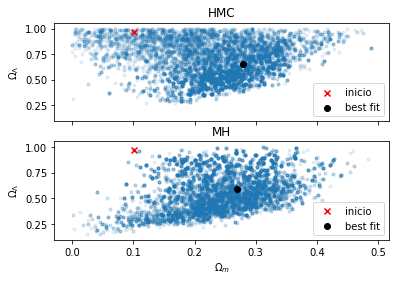

In [179]:
names = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$']
keys = ['om', 'ol']
plot(R_hmc, R_mh, keys, names, save='yes')

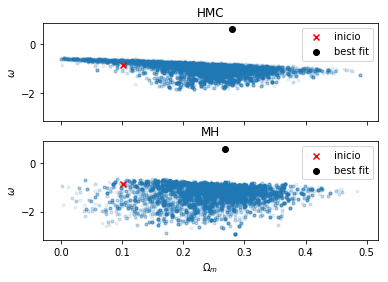

In [180]:
names = [r'$\Omega_{m}$', r'$\omega$']
keys = ['om', 'w']
plot(R_hmc, R_mh, keys, names, save='yes')

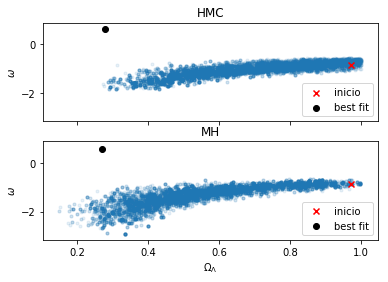

In [181]:
names = [r'$\Omega_{\Lambda}$', r'$\omega$']
keys = ['ol', 'w']
plot(R_hmc, R_mh, keys, names, save='yes please')

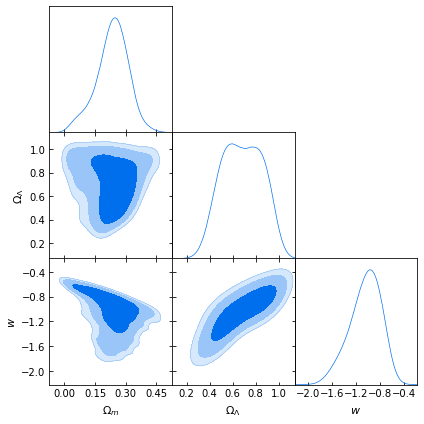

In [175]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity

ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
t1 = R_hmc[0]['om']
t2 = R_hmc[0]['ol']
t3 = R_hmc[0]['w']
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)


[ 1  1 10]


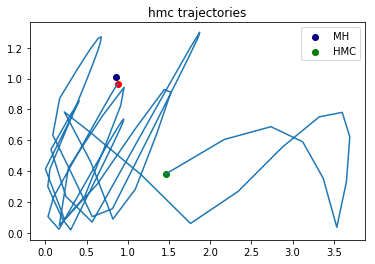

In [155]:
dw = 1e-6
e = 1e-2
l = 100
theta = q0

X, P, H = leapfrog(l=l, e=e, dw=dw, theta=q0, m=m, z=redshift, dat=mu_obs, sigma=cov)
XM = np.random.multivariate_normal(mean=q0, cov=cov_ini)
plt.plot(X[:, 0], X[:, 1])
plt.scatter(q0[0], q0[1], color='red')
plt.scatter(XM[0], XM[1], color='navy', label='MH')
plt.scatter(X[-1, 0], X[-1, 1], color='green', label='HMC')
plt.legend()
plt.title('hmc trajectories')
print(m)

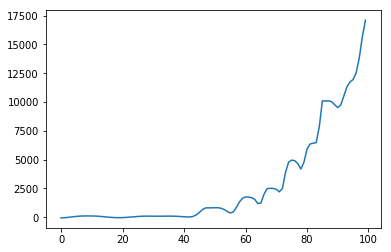

In [156]:
plt.plot(H)

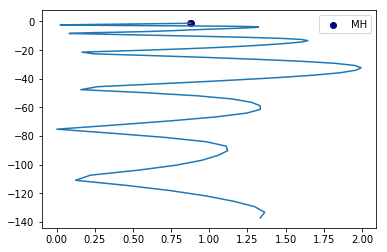

In [148]:
m[2] = 10
m[0] = 1e0
plt.plot(X[:, 0], X[:, 2])
plt.scatter(q0[0], q0[2], color='red')
plt.scatter(XM[0], XM[2], color='navy', label='MH')
plt.legend()